<a href="https://colab.research.google.com/github/Pointsh/NLP/blob/main/ChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Procject ChatBot
이번에는 chatbot을 구현했던 것을 정리해보려합니다.
koGPT2를 통해 구현했으며 오늘은 코랩을
통해 코드 내부에서 설명도 하고 
추가적으로 내용도 적어보겠습니다.

In [ ]:
import numpy as np
import pandas as pd
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.core.lightning import LightningModule
from torch.utils.data import DataLoader, Dataset
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel
import re

In [ ]:
Q_TKN = "<usr>"
A_TKN = "<sys>"
BOS = '</s>'
EOS = '</s>'
MASK = '<unused0>'
SENT = '<unused1>'
PAD = '<pad>'

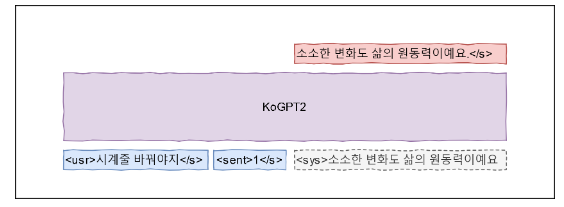

* 스페셜 토큰들의 설명을 다음과 같습니다.
* 데이터 Q필드를 < usr >발화, A필드를 < sys >발화 그리고 감정 레이블을 < sent >로 매핑해 P(< sys >|< usr >,< sent >)를 최대화 할 수 있는 모델을 학습시킵니다.

* 이후 huggingface transformer에 등록된 사전 학습된 koGPT2 model과 tokenizer를 가져옵니다.

In [ ]:
koGPT2_TOKENIZER = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
            bos_token=BOS, eos_token=EOS, unk_token='<unk>',
            pad_token=PAD, mask_token=MASK) 
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')

Downloading:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


Downloading:   0%|          | 0.00/513M [00:00<?, ?B/s]

In [ ]:
# 챗봇 데이터를 처리하는 클래스를 만든다.
class ChatbotDataset(Dataset):
    def __init__(self, chats, max_len=40):  # 데이터셋의 전처리를 해주는 부분
        self._data = chats
        self.max_len = max_len
        self.q_token = Q_TKN
        self.a_token = A_TKN
        self.sent_token = SENT
        self.eos = EOS
        self.mask = MASK
        self.tokenizer = koGPT2_TOKENIZER

    def __len__(self):  # chatbotdata 의 길이를 리턴한다.
        return len(self._data)

    def __getitem__(self, idx):  # 로드한 챗봇 데이터를 차례차례 DataLoader로 넘겨주는 메서드
        turn = self._data.iloc[idx]
        q = turn["Q"]  # 질문을 가져온다.
        q = re.sub(r"([?.!,])", r" ", q)  # 구둣점들을 제거한다.

        a = turn["A"]  # 답변을 가져온다.
        a = re.sub(r"([?.!,])", r" ", a)  # 구둣점들을 제거한다.

        q_toked = self.tokenizer.tokenize(self.q_token + q + self.sent_token)
        q_len = len(q_toked)

        a_toked = self.tokenizer.tokenize(self.a_token + a + self.eos)
        a_len = len(a_toked)

        #질문의 길이가 최대길이보다 크면
        if q_len > self.max_len:
            a_len = self.max_len - q_len        #답변의 길이를 최대길이 - 질문길이
            if a_len <= 0:       #질문의 길이가 너무 길어 질문만으로 최대 길이를 초과 한다면
                q_toked = q_toked[-(int(self.max_len / 2)) :]   #질문길이를 최대길이의 반으로 
                q_len = len(q_toked)
                a_len = self.max_len - q_len              #답변의 길이를 최대길이 - 질문길이
            a_toked = a_toked[:a_len]
            a_len = len(a_toked)

        #질문의 길이 + 답변의 길이가 최대길이보다 크면
        if q_len + a_len > self.max_len:
            a_len = self.max_len - q_len        #답변의 길이를 최대길이 - 질문길이
            if a_len <= 0:       #질문의 길이가 너무 길어 질문만으로 최대 길이를 초과 한다면
                q_toked = q_toked[-(int(self.max_len / 2)) :]   #질문길이를 최대길이의 반으로 
                q_len = len(q_toked)
                a_len = self.max_len - q_len              #답변의 길이를 최대길이 - 질문길이
            a_toked = a_toked[:a_len]
            a_len = len(a_toked)

        # 답변 labels = [mask, mask, ...., mask, ..., <bos>,..답변.. <eos>, <pad>....]
        labels = [self.mask,] * q_len + a_toked[1:]

        # mask = 질문길이 0 + 답변길이 1 + 나머지 0
        mask = [0] * q_len + [1] * a_len + [0] * (self.max_len - q_len - a_len)
        # 답변 labels을 index 로 만든다.
        labels_ids = self.tokenizer.convert_tokens_to_ids(labels)
        # 최대길이만큼 PADDING
        while len(labels_ids) < self.max_len:
            labels_ids += [self.tokenizer.pad_token_id]

        # 질문 + 답변을 index 로 만든다.    
        token_ids = self.tokenizer.convert_tokens_to_ids(q_toked + a_toked)
        # 최대길이만큼 PADDING
        while len(token_ids) < self.max_len:
            token_ids += [self.tokenizer.pad_token_id]

        #질문+답변, 마스크, 답변
        return (token_ids, np.array(mask), labels_ids)

In [ ]:
def collate_batch(batch):
    data = [item[0] for item in batch]
    mask = [item[1] for item in batch]
    label = [item[2] for item in batch]
    return torch.LongTensor(data), torch.LongTensor(mask), torch.LongTensor(label)

In [ ]:
#데이터셋 불러오는 부분
import urllib.request

urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv",
    filename="ChatBotData.csv",
)
Chatbot_Data = pd.read_csv("ChatBotData.csv")

# Test 용으로 300개 데이터만 처리한다.
# Chatbot_Data = Chatbot_Data[:300]
# Chatbot_Data.head(20)

In [ ]:
Chatbot_Data = pd.read_csv("totaldf.csv")

In [ ]:
Chatbot_Data.drop('label',axis=1,inplace=True)

In [ ]:
Chatbot_Data[Chatbot_Data['Q'].str.contains('점심')]

,Q,A,label
3310,오늘 점심 뭐 먹을까,냉면은 어떠세요?,0
3311,오늘 점심은,날씨도 추운데 뜨끈한 국물 드세요!,0
4116,점심 도시락 싸는 거 귀찮다,건강을 챙긴다는 마음으로 해보세요.,0
4117,점심 때 은행 갔다와야지,볼 일이 있나봐요.,0
4118,점심 먹어야지,즐거운 시간 보내시길 바랍니다.,0
4119,점심 메뉴 고르는 거 힘드네,맞아요 항상 고민이 되죠.,0
4120,점심 메뉴 좀 골라줘,주변 분들의 얘기를 들어보는건 어떨까요?,0
4121,점심시간 너무 짧아,일하는 시간은 길죠.,0
4122,점심시간에 외출하는 것도 눈치봐야돼,정말 너무하네요 개인적인 시간인데.,0
4123,점심시간에 외출하면 안 되나,시간안에만 온다면 가능하죠.,0


In [ ]:
Chatbot_Data.A.loc[4122]='정말 너무하네요 개인적인 시간인데.'

In [ ]:
Chatbot_Data.A.loc[4123]='시간안에만 온다면 가능하죠.'

In [ ]:
Chatbot_Data.A.loc[4119]='맞아요 항상 고민이 되죠.'

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
Chatbot_Data.A.loc[4119]='맞아요 항상 고민이되죠.'

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
Chatbot_Data.A.loc[4120]='주변 분들의 얘기를 들어보는건 어떨까요?'

In [ ]:
Chatbot_Data.A.loc[3311]='날씨도 추운데 뜨끈한 국물 드세요!'

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
Chatbot_Data.A.loc[808]='그럴리가요 확인해보세요.'

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


* 저는 추가적으로 데이터셋의 어색한 부분이나 꼬인부분을 별도로 확인하여 수정하였습니다.

In [ ]:
Chatbot_Data=Chatbot_Data.copy()

In [ ]:
Chatbot_Data.to_csv('chatbotdata.csv',encoding='cp949')

In [ ]:
Chatbot_Data.A.loc[3691]='쫑긋이에요.'

In [ ]:
device = torch.device('cuda')

In [ ]:
train_set = ChatbotDataset(Chatbot_Data, max_len=40)
#윈도우 환경에서 num_workers 는 무조건 0으로 지정, 리눅스에서는 2
train_dataloader = DataLoader(train_set, batch_size=32, num_workers=2, shuffle=True, collate_fn=collate_batch,)

In [ ]:
model.train()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [ ]:
Chatbot_Data.drop(['Unnamed: 0','구분'],axis=1,inplace=True)

In [ ]:
Chatbot_Data.rename(columns = {'유저' : 'Q','챗봇':'A'}, inplace = True)

In [ ]:
Chatbot_Data.to_csv('datset.csv',encoding='cp949')

In [ ]:
learning_rate = 5e-5
criterion = torch.nn.CrossEntropyLoss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch = 10
Sneg = -1e18

In [ ]:
torch.cuda.empty_cache() #cuda의 cache memory가 비어있는지 확인

In [ ]:
print ("start")
for epoch in range(epoch):
    for batch_idx, samples in enumerate(train_dataloader):
        optimizer.zero_grad()
        token_ids, mask, label = samples
        out = model(token_ids)
        out = out.logits      #Returns a new tensor with the logit of the elements of input
        mask_3d = mask.unsqueeze(dim=2).repeat_interleave(repeats=out.shape[2], dim=2)
        mask_out = torch.where(mask_3d == 1, out, Sneg * torch.ones_like(out))
        loss = criterion(mask_out.transpose(2, 1), label)
        # 평균 loss 만들기 avg_loss[0] / avg_loss[1] <- loss 정규화
        avg_loss = loss.sum() / mask.sum()
        avg_loss.backward()
        # 학습 끝
        optimizer.step()
print ("end")

start


<ipython-input-10-495d11317178>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.LongTensor(data), torch.LongTensor(mask), torch.LongTensor(label)
<ipython-input-10-495d11317178>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.LongTensor(data), torch.LongTensor(mask), torch.LongTensor(label)
<ipython-input-10-495d11317178>:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally a

In [ ]:
with torch.no_grad():
    while 1:
        q = input("user > ").strip()
        if q == "quit":
            break
        a = ""
        while 1:
            input_ids = torch.LongTensor(koGPT2_TOKENIZER.encode(Q_TKN + q  + A_TKN + a)).unsqueeze(dim=0)
            pred = model(input_ids)
            pred = pred.logits
            gen = koGPT2_TOKENIZER.convert_ids_to_tokens(torch.argmax(pred, dim=-1).squeeze().numpy().tolist())[-1]
            if gen == EOS:
                break
            a += gen.replace("▁", " ")
        print("Chatbot > {}".format(a.strip()))

In [ ]:
PATH = ''

In [ ]:
torch.save(model,PATH+'save_model')

마지막으로 model을 저장하는 이유는 해당 모델을 가지고 이후 streamlit을 통한 UI가 있는 ChatBot을 구현하기 위함입니다.